## Disease Condition prediction based on drug reviews

In this project, we will classify the condition of patients using the reviews of the drugs given by patients using drug reviews dataset available in [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29).

## Importing libraries

In [1]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

In [3]:
df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [4]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [5]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]

In [6]:
df.shape

(161297, 7)

In [7]:
df_train.shape

(42732, 7)

In [8]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

## EDA

In [9]:
X.condition.value_counts()

condition
Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: count, dtype: int64

In [10]:
X.head()

condition                                             review
2   Birth Control  "I used to take another oral contraceptive, wh...
3   Birth Control  "This is my first time using any form of birth...
9   Birth Control  "I had been on the pill for many years. When m...
11     Depression  "I have taken anti-depressants for years, with...
14  Birth Control  "Started Nexplanon 2 months ago because I have...

In [11]:
X.isna().sum()

condition    0
review       0
dtype: int64

In [12]:
X.duplicated()

2         False
3         False
9         False
11        False
14        False
22        False
31        False
44        False
50        False
59        False
61        False
63        False
64        False
67        False
68        False
74        False
75        False
77        False
81        False
82        False
83        False
90        False
96        False
97        False
104       False
113       False
117       False
118       False
122       False
123       False
127       False
133       False
138       False
139       False
143       False
144       False
146       False
150       False
152       False
153       False
154       False
155       False
157       False
162       False
163       False
169       False
171       False
182       False
183       False
184       False
185       False
186       False
187       False
190       False
194       False
199       False
205       False
216       False
218       False
219       False
222       False
223       False
225     

In [13]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

Text(0.5, 1.0, 'Word cloud for Birth control')

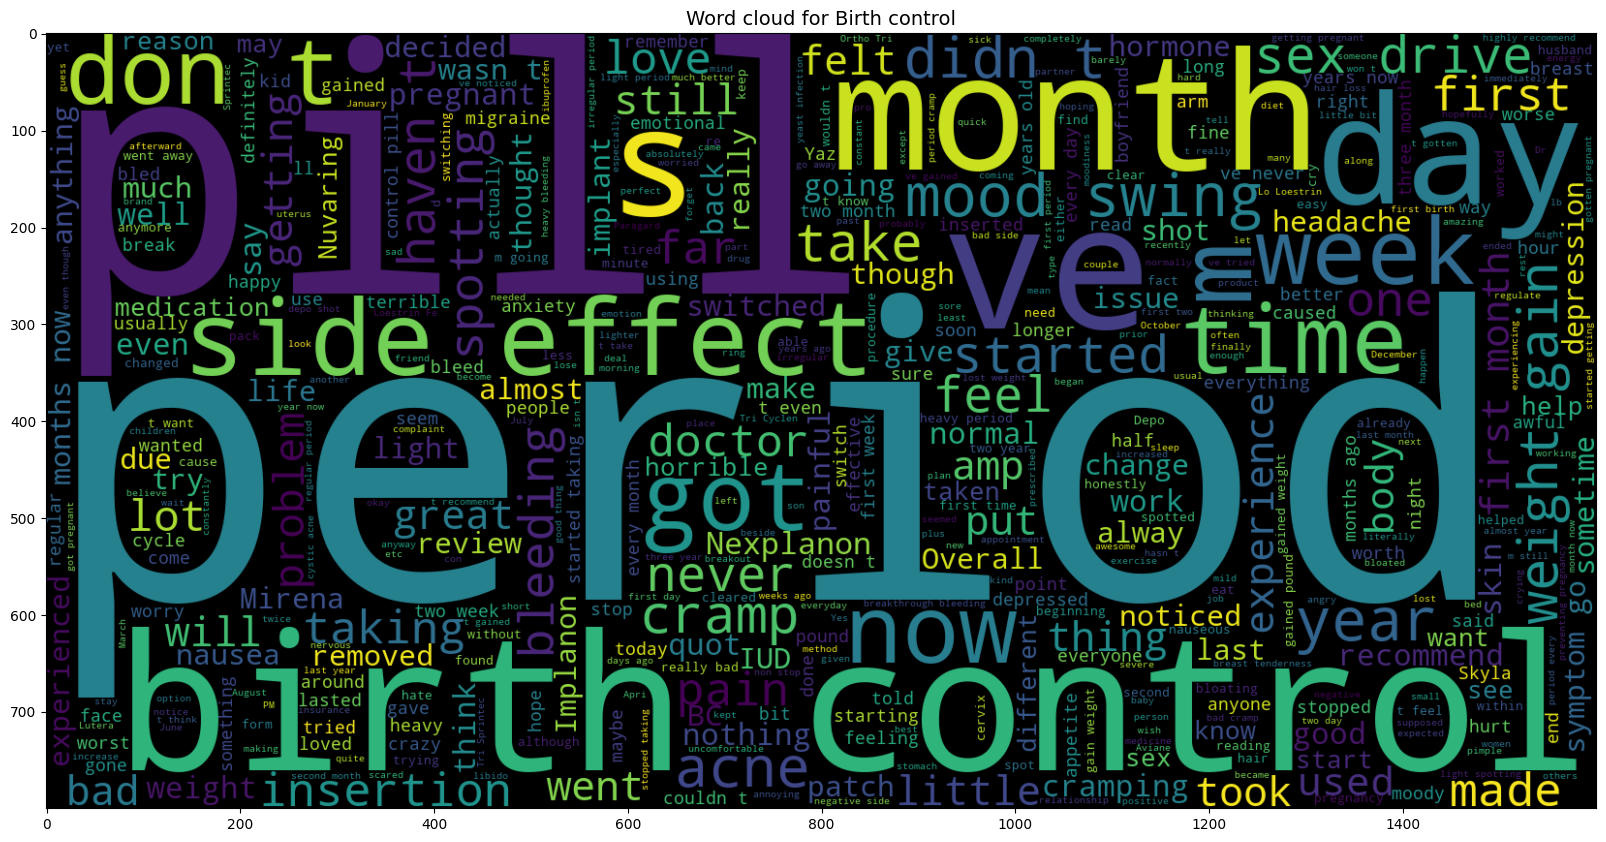

In [14]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_birth.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

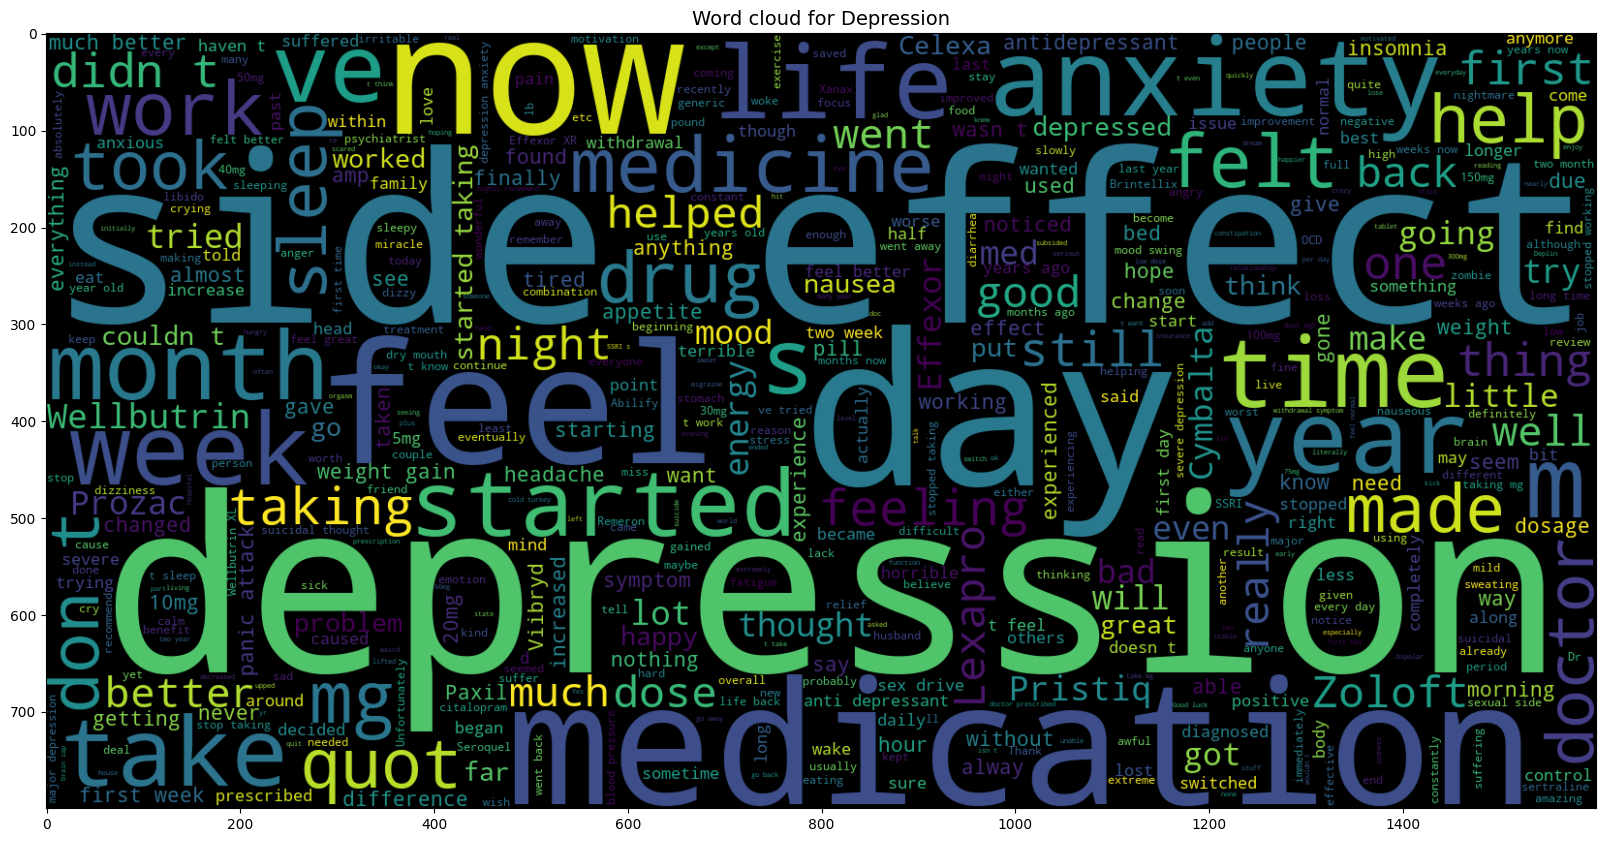

In [15]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

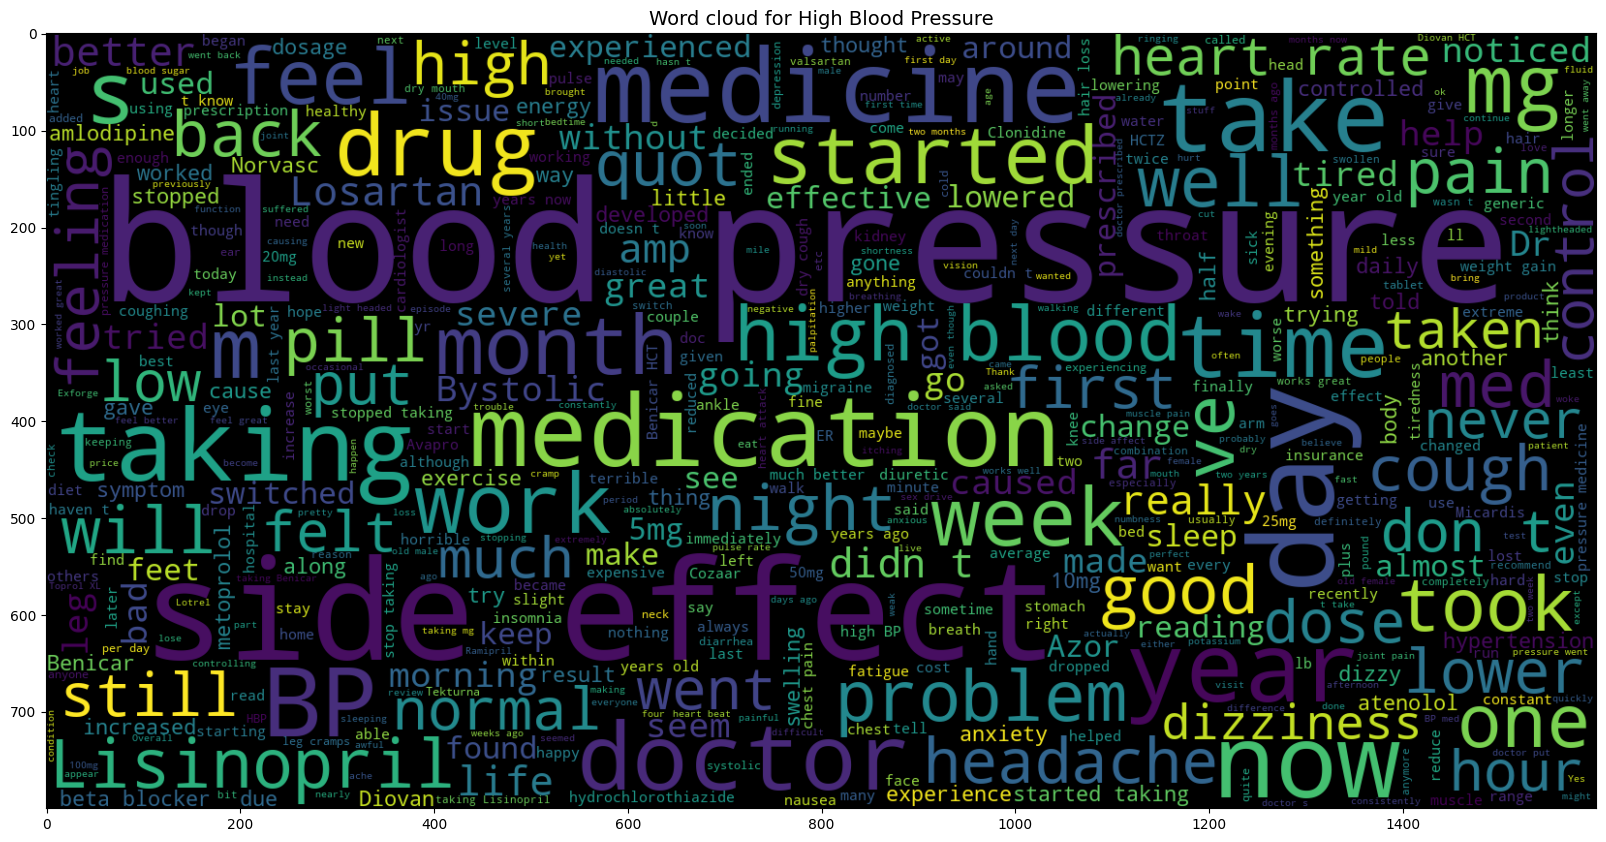

In [16]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

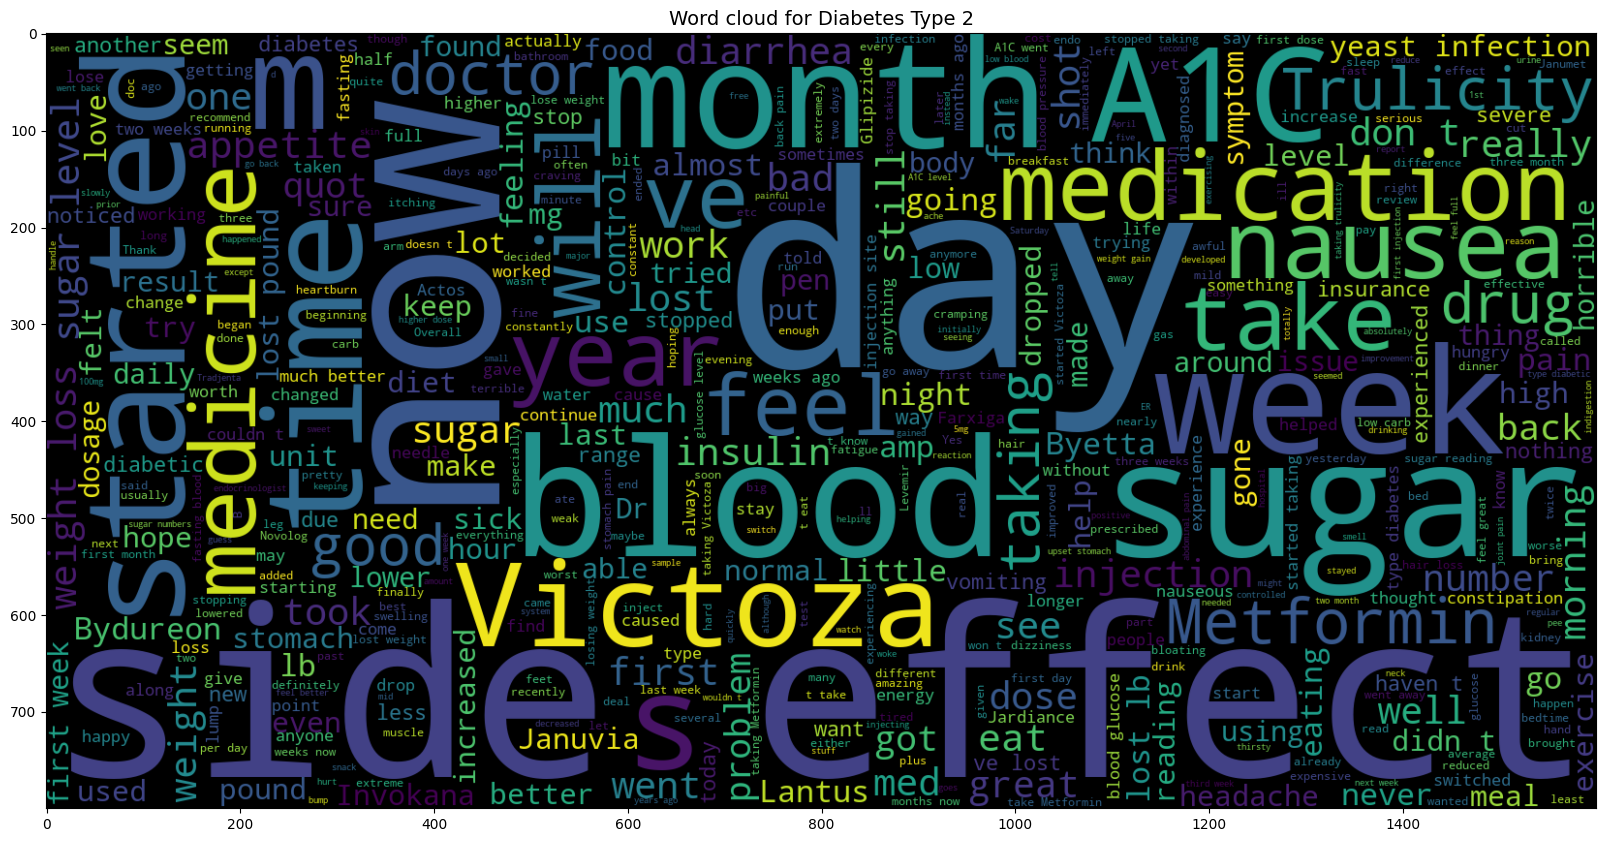

In [17]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

## data preprocessing

In [18]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [19]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [20]:
# To remove double quotes
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [22]:
# To set the width of the column to maximum
#pd.set_option('max_colwidth', -1)

In [23]:
X.head()

condition                                             review
2   Birth Control  I used to take another oral contraceptive, whi...
3   Birth Control  This is my first time using any form of birth ...
9   Birth Control  I had been on the pill for many years. When my...
11     Depression  I have taken anti-depressants for years, with ...
14  Birth Control  Started Nexplanon 2 months ago because I have ...

In [24]:
# removing stop words
from nltk.corpus import stopwords

stop = stopwords.words('english')


In [25]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Lemmitization


In [26]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [27]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [28]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

sportingly
very
troubled


In [29]:
from bs4 import BeautifulSoup 
import re

In [30]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [31]:
X['review_clean'] = X['review'].apply(review_to_words)

In [32]:
X.head()

condition                                             review  \
2   Birth Control  I used to take another oral contraceptive, whi...   
3   Birth Control  This is my first time using any form of birth ...   
9   Birth Control  I had been on the pill for many years. When my...   
11     Depression  I have taken anti-depressants for years, with ...   
14  Birth Control  Started Nexplanon 2 months ago because I have ...   

                                         review_clean  
2   used take another oral contraceptive pill cycl...  
3   first time using form birth control glad went ...  
9   pill many year doctor changed rx chateal effec...  
11  taken anti depressant year improvement mostly ...  
14  started nexplanon month ago minimal amount con...

## Creating features and Target Variable

In [33]:
X_feat=X['review_clean']
y=X['condition']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Bag of Words

In [36]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [37]:
count_train

<34185x15995 sparse matrix of type '<class 'numpy.int64'>'
	with 1092752 stored elements in Compressed Sparse Row format>

## Machine Learning Model : Naive Bayes

accuracy:   0.970
Confusion matrix, without normalization


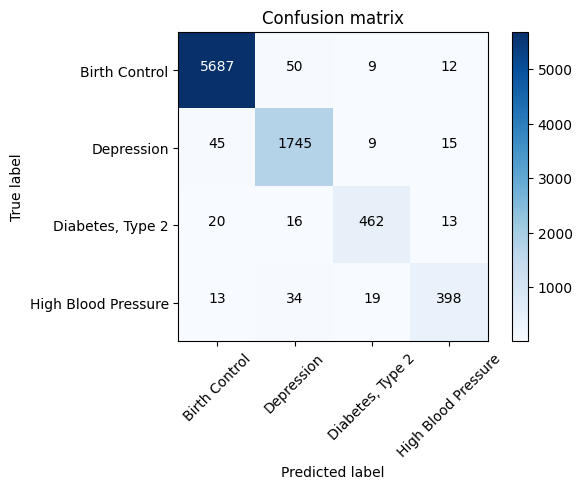

In [38]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model : Passive Aggressive Classifier

accuracy:   0.978
Confusion matrix, without normalization


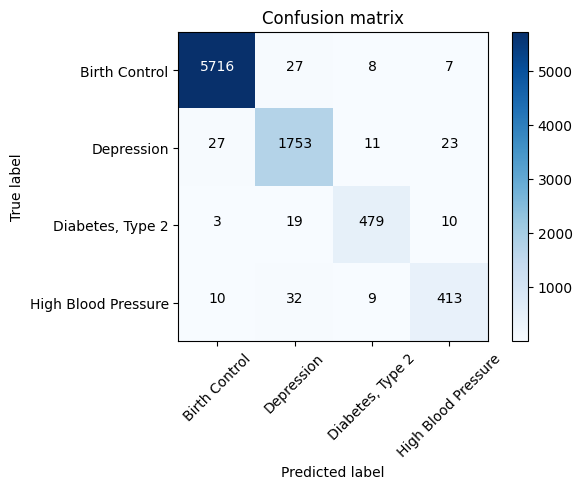

In [39]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### TFIDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Machine Learning Model : Naive Bayes

accuracy:   0.921
Confusion matrix, without normalization


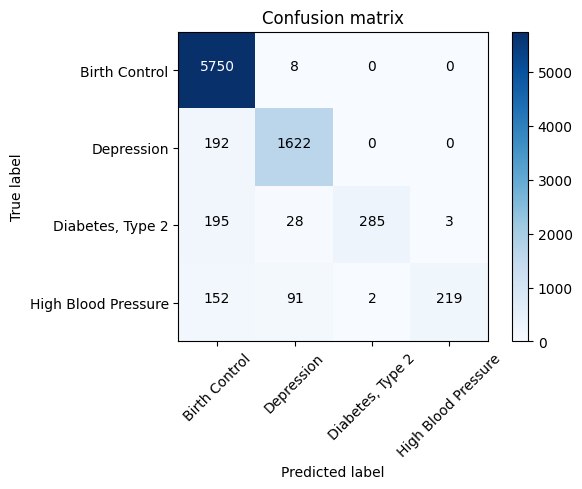

In [41]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model TFIDF

accuracy:   0.982
Confusion matrix, without normalization


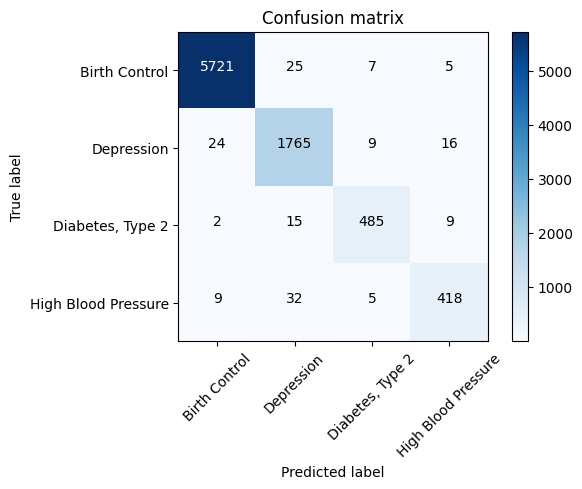

In [52]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])


## TFIDF: Bigrams

In [43]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

accuracy:   0.986
Confusion matrix, without normalization


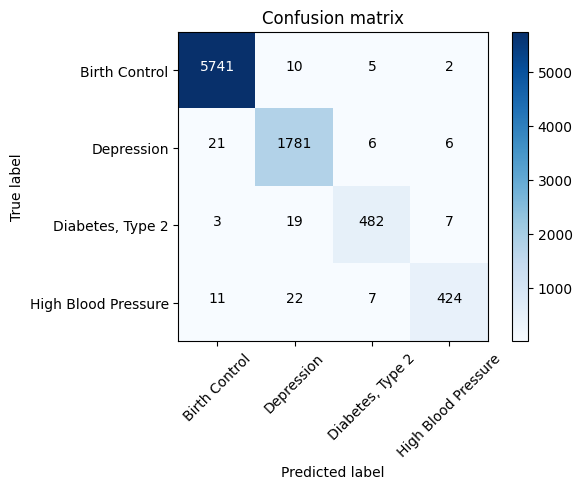

In [44]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF : Trigrams

accuracy:   0.985
Confusion matrix, without normalization


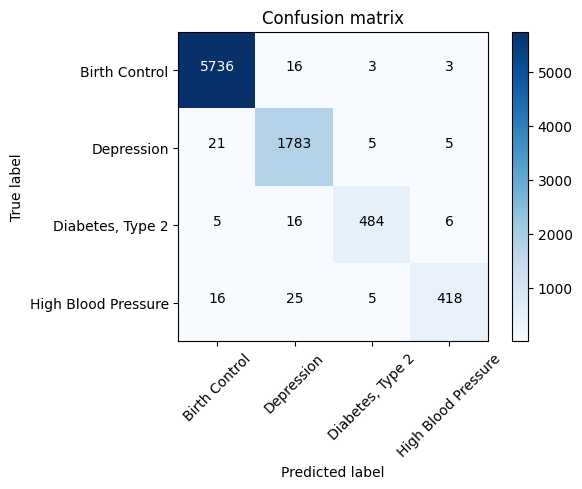

In [45]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Most important Features

In [46]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)



most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')

Birth Control comb 0.4955577826599064
Birth Control correct 0.5158937593472701
Birth Control tricyclone 0.5299598244481508
Birth Control tricylcen 0.5299598244481508
Birth Control aesthetician 0.5494407480907029
Birth Control packaged 0.6240023106590794
Birth Control addon 0.6300985597055705
Birth Control tiny 0.7302041817958335
Birth Control commit 1.2820360650036862
Birth Control freeway 7.070157891416699


In [47]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression strung 0.5780088617748095
Depression sleepingpills 0.5806264105225015
Depression therefor 0.5848644591579594
Depression sinnce 0.6293813889569898
Depression develope 0.6679782059386357
Depression assaulted 0.7689968454829939
Depression significantly 0.9018124785745211
Depression subjective 0.9869800644140747
Depression apnea 1.1283088965099606
Depression aliveness 3.6767309900467358


In [48]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

High Blood Pressure fatter 0.5403243143322858
High Blood Pressure fattest 0.5403243143322858
High Blood Pressure folic 0.5518156157914038
High Blood Pressure end 0.5636284945083319
High Blood Pressure encouraged 0.6026891827601778
High Blood Pressure fluctuation 0.6037728134638675
High Blood Pressure barley 0.6081641757499961
High Blood Pressure enforcement 0.6945405896406391
High Blood Pressure shine 0.7414910935716827
High Blood Pressure folk 1.0352134613402804


In [49]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 aesthetician 0.3440838592156619
Diabetes, Type 2 vastly 0.3704507020756395
Diabetes, Type 2 prom 0.4693992715183578
Diabetes, Type 2 absorbs 0.4702427529735933
Diabetes, Type 2 fluctuation 0.4730346976097036
Diabetes, Type 2 base 0.5120386607656964
Diabetes, Type 2 proliferating 0.6237028998091351
Diabetes, Type 2 fot 0.7612780325811662
Diabetes, Type 2 orthotricyclenlo 0.7906847491745076
Diabetes, Type 2 problem 3.106136904994659


## Sample Predictions

In [50]:
X.tail()

condition  \
161273        Birth Control   
161278     Diabetes, Type 2   
161286           Depression   
161290  High Blood Pressure   
161291        Birth Control   

                                                   review  \
161273  I have had the Nexplanon since Dec. 27, 2016 \...   
161278  I just got diagnosed with type 2. My doctor pr...   
161286  This is the third med I&#039;ve tried for anxi...   
161290  I have only been on Tekturna for 9 days. The e...   
161291  This would be my second month on Junel. I&#039...   

                                             review_clean  
161273  nexplanon since dec got first period end janua...  
161278  got diagnosed type doctor prescribed invokana ...  
161286  third med tried anxiety mild depression week h...  
161290  tekturna day effect immediate also calcium cha...  
161291  would second month junel birth control year ch...

In [53]:
text =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'High Blood Pressure'

In [54]:
text =["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Depression'

In [55]:
text =["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Diabetes, Type 2'